This project focuses on possibility of predicting the outcome of a single football match using data of all matches in English Premier League for last 5 and half seasons. First I will try to make predictions using different classifiers like RF and Logistic Regression and then try to implement Deep Learning approach.

DISCLAIMER: Once I again I used some code structures and ideas from these sources (https://github.com/dataquestio/project-walkthroughs/blob/master/football_matches/scraping.ipynb,  https://michael-fuchs-python.netlify.app/2021/02/23/nn-artificial-neural-network-for-multi-class-classfication/, https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)



In [28]:
import requests
from bs4 import BeautifulSoup
import time
from urllib.request import Request
import re
from urllib.request import urlopen
from urllib.request import Request
from urllib.error import URLError
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import math
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import os
import pickle as pk
from tensorflow.keras import optimizers
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score

I need stats that play the biggest role in determining the winner of the game. But not obvious ones like goals scored and allowed. Stats that first come to mind are xG and xGA, goal creation stats, passing stats. In further projects it will be a good idea to include pressing stats into prediction process because quality of pressing nowadays plays a big role in overall performance of a team. I couldn't find pressing metrics stats on Football ref website so I decided not to include it in this project.

We start with Web Scraping of the FBRef website where I found the stats I needed for the prediction. I had to do the scraping in 4 steps and add significant timesleep as 10 sec just to be sure that FBRef won't bann me for an hour.

In [4]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(10)

In [5]:
ttable = pd.concat(all_matches)

In [ ]:
ttable = ttable.astype({'GF':'int'})
ttable = ttable.astype({'GA':'int'})
ttable=ttable.reset_index()
ttable.drop('index',axis=1,inplace=True)

In [7]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/passing/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        passing = pd.read_html(data.text, match="Passing")[0]
        passing.columns = passing.columns.droplevel()
        
        try:
            team_data1 = matches.merge(passing[["Date", "KP", "1/3", "PPA", "CrsPA", "Prog"]], on="Date")
        except ValueError:
            continue 
        team_data1 = team_data1[team_data1["Comp"] == "Premier League"]
        
        team_data1["Season"] = year
        team_data1["Team"] = team_name
        all_matches.append(team_data1)
        time.sleep(10)

In [8]:
assists = pd.concat(all_matches)
assists=assists.reset_index()
assists.drop('index',axis=1,inplace=True)

In [11]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/possession/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        possession = pd.read_html(data.text, match="Possession")[0]
        possession.columns = possession.columns.droplevel()
        
        try:
            team_data2= matches.merge(possession[["Date", "Att 3rd", "Att Pen", "Prog"]], on="Date")
        except ValueError:
            continue  
        team_data2 = team_data2[team_data2["Comp"] == "Premier League"]
                
        team_data2["Season"] = year
        team_data2["Team"] = team_name
        all_matches.append(team_data2)
        time.sleep(10)

In [12]:
posses = pd.concat(all_matches)
posses=posses.reset_index()
posses.drop('index',axis=1,inplace=True)

In [14]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/gca/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        gfc = pd.read_html(data.text, match="Goal and Shot Creation")[0]
        gfc.columns = gfc.columns.droplevel()
        
        try:
            team_data3 = matches.merge(gfc[["Date", "SCA"]], on="Date")
        except ValueError:
            continue  
        team_data3 = team_data3[team_data3["Comp"] == "Premier League"]    
        
                
        team_data3["Season"] = year
        team_data3["Team"] = team_name
        all_matches.append(team_data3)
        time.sleep(10)

In [15]:
creation = pd.concat(all_matches)
creation=creation.reset_index()
creation.drop('index',axis=1,inplace=True)

In [17]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/passing_types/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        passing_type = pd.read_html(data.text, match="Pass Types")[0]
        passing_type.columns = passing_type.columns.droplevel()
        
        try:
            team_data5 = matches.merge(passing_type[["Date", "TB"]], on="Date")
        except ValueError:
            continue
        team_data5 = team_data5[team_data5["Comp"] == "Premier League"]   
        
                
        team_data5["Season"] = year
        team_data5["Team"] = team_name
        all_matches.append(team_data5)
        time.sleep(10)

In [18]:
back1=pd.concat(all_matches)
back1=back1.reset_index()
back1.drop('index',axis=1,inplace=True)

Let me explain the stats:


Main stats

xG - expected goals

xGA - expected allowed goals

Poss - possession of the ball

GF - goals scored

GA - goals allowed


Shooting stats

"Sh" - total number of shots

"SoT" - shots on target

"Dist" - average distance in yards from goal of all shots taken

"FK" - shots from free kicks

"PK" - penalty kicks made

"PKatt" - penalty kicks attempted


Passing stats

"KP" - passes that directly lead to a shot

"1/3" - completed passes that enter the final third of the pitch on offense

"PPA" - completed passes into the 18-yard box not including set pieces

"CrsPA" - completed crosse into the 18-yard box

"Prog" - progressive passes, completed passes that move the ball towards the opponent's goal at least 10 yards from its 
furthest point in the last six passes, or any completed pass into the penalty area.


Possession stats

"Att 3rd" - touches in attacking third of the pitch

"Att Pen" - touches in attacking penalty area

"Prog" - progressive passes recieved, completed passes that move the ball towards the opponent's goal at least 10 yards from 
its furthest point in the last six passes, or any completed pass into the penalty area.


Goal and Shot Creation stats

"SCA" - shot-creating actions, the two offensive actions directly leading to a shot such as passes, dribbles and drawing fouls.


Pass type stats

"TB" - completed pass sent between back defenders into open space.



Okay, so I have 5 dataframes with all fixtures of every team for the current season and previous 5 seasons. I can concatenate them now. 


I will add the code lines in which I read all the stats from csv files that I made beforehand. I am doing this in order to run this code on Kaggle in a faster way than it would run with scraping the web page.

In [2]:
ttable=pd.read_csv('main17-23.csv')
assists=pd.read_csv('assists_2017-2023.csv')
posses=pd.read_csv('possession_2017-2023.csv')
creation=pd.read_csv('Creation_17-23.csv')
back1=pd.read_csv('TB_17-23.csv')

Unofortunately, something was wrong during the process of scraping and I couldn't easily concatenate the dataframes using pandas(merging on the date of the game for example). So I made a function that does it.

In [3]:
def conc():
    newt=ttable
    main=["Sh", "SoT", "Dist", "FK", "PK", "PKatt",'GF','GA','xG','xGA','Poss']
    asss=["KP", "1/3", "PPA", "CrsPA", "Prog"]
    posss=["Att 3rd", "Att Pen", "Prog"]
    feat=["KP", "1/3", "PPA", "CrsPA", "Prog","Att 3rd", "Att Pen", "Prog",'SCA','TB']
    for i in feat:
        newt[i]=0
    
    for j in asss:
        for i in range(len(newt)):
            if (newt['Date'][i]==assists['Date'][i])&(newt['Team'][i]==assists['Team'][i])&(newt['Opponent'][i]==assists['Opponent'][i]):
                newt[j][i]=assists[j][i]    
                
    for j in posss:
        for i in range(len(newt)):
            if (newt['Date'][i]==posses['Date'][i])&(newt['Team'][i]==posses['Team'][i])&(newt['Opponent'][i]==posses['Opponent'][i]):
                newt[j][i]=posses[j][i]            
                
    for i in range(len(newt)):
        if (newt['Date'][i]==creation['Date'][i])&(newt['Team'][i]==creation['Team'][i])&(newt['Opponent'][i]==creation['Opponent'][i]):
            newt['SCA'][i]=creation['SCA'][i]           
            
    for i in range(len(ttable)):
        if (newt['Date'][i]==back1['Date'][i])&(newt['Team'][i]==back1['Team'][i])&(newt['Opponent'][i]==back1['Opponent'][i]):
            newt['TB'][i]=back1['TB'][i]   
            
            
    return newt        

In [4]:
newt=conc()

<ipython-input-3-8bee9935a392>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newt[j][i]=assists[j][i]
<ipython-input-3-8bee9935a392>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newt[j][i]=posses[j][i]
<ipython-input-3-8bee9935a392>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newt['SCA'][i]=creation['SCA'][i]
<ipython-input-3-8bee9935a392>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [5]:
newt.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Team,KP,1/3,PPA,CrsPA,Prog,Att 3rd,Att Pen,SCA,TB
0,2022-08-05,20:00,Premier League,Matchweek 1,Fri,Away,W,2.0,0.0,Crystal Palace,...,Arsenal,7,34,10,0,31,135,29,18,0
1,2022-08-13,15:00,Premier League,Matchweek 2,Sat,Home,W,4.0,2.0,Leicester City,...,Arsenal,14,29,7,2,22,221,34,34,2
2,2022-08-20,17:30,Premier League,Matchweek 3,Sat,Away,W,3.0,0.0,Bournemouth,...,Arsenal,9,24,6,2,22,172,17,25,0
3,2022-08-27,17:30,Premier League,Matchweek 4,Sat,Home,W,2.0,1.0,Fulham,...,Arsenal,16,42,17,3,43,241,48,36,2
4,2022-08-31,19:30,Premier League,Matchweek 5,Wed,Home,W,2.0,1.0,Aston Villa,...,Arsenal,15,40,16,0,38,197,44,38,1


In [6]:
newt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4092 non-null   object 
 1   Time          4092 non-null   object 
 2   Comp          4092 non-null   object 
 3   Round         4092 non-null   object 
 4   Day           4092 non-null   object 
 5   Venue         4092 non-null   object 
 6   Result        4092 non-null   object 
 7   GF            4092 non-null   float64
 8   GA            4092 non-null   float64
 9   Opponent      4092 non-null   object 
 10  xG            4092 non-null   float64
 11  xGA           4092 non-null   float64
 12  Poss          4092 non-null   float64
 13  Attendance    3212 non-null   float64
 14  Captain       4092 non-null   object 
 15  Formation     4092 non-null   object 
 16  Referee       4092 non-null   object 
 17  Match Report  4092 non-null   object 
 18  Notes         0 non-null    

Okay so we got one table with all fixtures for the last 5.5 seasons. There were missing values in distance stats:

In [7]:
avgdist=newt['Dist'].mean()
def dist(x):
    if math.isnan(x):
        return avgdist
    else:
        return x
newt['Dist']=newt['Dist'].apply(lambda x:dist(x))

Let's make a result column numeric.

In [8]:
le = LabelEncoder()
newt1=newt
newt1['Result'] = le.fit_transform(newt1['Result'])

In [9]:
newt1.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Team,KP,1/3,PPA,CrsPA,Prog,Att 3rd,Att Pen,SCA,TB
0,2022-08-05,20:00,Premier League,Matchweek 1,Fri,Away,2,2.0,0.0,Crystal Palace,...,Arsenal,7,34,10,0,31,135,29,18,0
1,2022-08-13,15:00,Premier League,Matchweek 2,Sat,Home,2,4.0,2.0,Leicester City,...,Arsenal,14,29,7,2,22,221,34,34,2
2,2022-08-20,17:30,Premier League,Matchweek 3,Sat,Away,2,3.0,0.0,Bournemouth,...,Arsenal,9,24,6,2,22,172,17,25,0
3,2022-08-27,17:30,Premier League,Matchweek 4,Sat,Home,2,2.0,1.0,Fulham,...,Arsenal,16,42,17,3,43,241,48,36,2
4,2022-08-31,19:30,Premier League,Matchweek 5,Wed,Home,2,2.0,1.0,Aston Villa,...,Arsenal,15,40,16,0,38,197,44,38,1


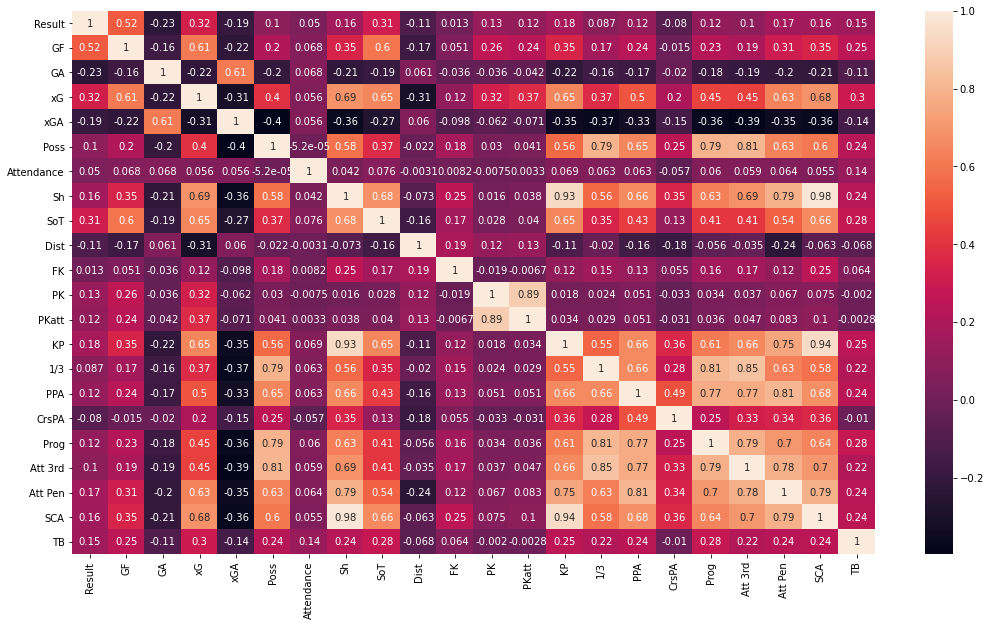

In [11]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(newt1.drop(['Date','Time','Comp','Round','Day','Venue','Captain','Formation','Referee','Match Report','Notes','Season','Team'],axis=1).corr(),annot=True)

Now we can see correlations between type of result and other features. Of course goals scored has the best correlation. Second best is xG which is also understandable and good for our prediction. Next goes shots on target stats, KP and Att Pen. xG has good correlation with all passing and chances creating metrics. Possesion of the ball alone doesn't guarantee winning but adds to xG and passing stats which is pretty realistic.

Now let's try basic classifiers first.

In [13]:
X=newt1.drop(['Date','Time','Comp','Round','Day','Venue','Captain','Formation',
             'Referee','Match Report','Notes','Season','Team','Opponent','Attendance','Result','GF','GA'],axis=1)

In [14]:
y=newt1['Result']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
knn_prob=knn.predict_proba(X_test)[:,0-1]

logmodel=LogisticRegression(max_iter=2000)
logmodel.fit(X_train,y_train)
pred_log=logmodel.predict(X_test)
log_prob=logmodel.predict_proba(X_test)[:,0-1]

rfc=RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
pred_rfc=rfc.predict(X_test)
rfc_prob=rfc.predict_proba(X_test)[:,0-1]


print('Logistic Regression')
print(confusion_matrix(y_test,pred_log))
print(classification_report(y_test,pred_log))

print('Random Forest')
print(confusion_matrix(y_test,pred_rfc))
print(classification_report(y_test,pred_rfc))


print('K Nearest Neighbor')
print(confusion_matrix(y_test,pred_knn))
print(classification_report(y_test,pred_knn))


Logistic Regression
[[ 31 164 114]
 [ 27 400  69]
 [ 27  97 422]]
              precision    recall  f1-score   support

           0       0.36      0.10      0.16       309
           1       0.61      0.81      0.69       496
           2       0.70      0.77      0.73       546

    accuracy                           0.63      1351
   macro avg       0.56      0.56      0.53      1351
weighted avg       0.59      0.63      0.59      1351

Random Forest
[[ 45 150 114]
 [ 49 369  78]
 [ 37  89 420]]
              precision    recall  f1-score   support

           0       0.34      0.15      0.20       309
           1       0.61      0.74      0.67       496
           2       0.69      0.77      0.73       546

    accuracy                           0.62      1351
   macro avg       0.55      0.55      0.53      1351
weighted avg       0.58      0.62      0.59      1351

K Nearest Neighbor
[[ 74 110 125]
 [116 235 145]
 [117 185 244]]
              precision    recall  f1-score   s

Logistic regression gave slightly better accuracy then Random Forest classifier.

Let's try Deep Learning approach with TensorFlow.

In [39]:
X=newt1.drop(['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 
              'GF', 'GA','Opponent','Attendance','Captain', 'Formation','Referee', 'Match Report', 'Notes','Season','Team','Result'],axis=1)

In [40]:
y=newt1['Result']

In [41]:
encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

encoded_Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [42]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(X, encoded_Y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

In [43]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(2864, 18)
(614, 18)
(614, 18)


In [44]:
input_shape = trainX.shape[1]

n_batch_size = 20

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 100

num_classes = trainY.shape[1]

print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))
print()
print('Number of Classes: ' + str(num_classes))

Input Shape: 18
Batch Size: 20

Steps per Epoch: 143

Validation Steps: 30
Test Steps: 30

Number of Epochs: 100

Number of Classes: 3


In [45]:
scaler = MinMaxScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)



testX = scaler.transform(testX)
valX = scaler.transform(valX)


In [46]:
trainX=np.nan_to_num(trainX)
valX=np.nan_to_num(valX)
testX=np.nan_to_num(testX)

In [68]:
model = models.Sequential()
model.add(layers.Dense(64, activation='LeakyReLU', input_shape=(input_shape,)))
model.add(Dropout(0.25))
model.add(layers.Dense(64, activation='LeakyReLU'))
model.add(Dropout(0.25))
model.add(layers.Dense(64, activation='LeakyReLU'))
model.add(Dropout(0.25))
model.add(layers.Dense(64, activation='LeakyReLU'))
model.add(Dropout(0.25))
model.add(layers.Dense(64, activation='LeakyReLU'))
model.add(Dropout(0.25))
model.add(layers.Dense(64, activation='LeakyReLU'))
model.add(Dropout(0.25))
model.add(Dense(units=64,activation='LeakyReLU'))
model.add(Dropout(0.25))
model.add(Dense(units=64,activation='LeakyReLU'))
#
model.add(Dropout(0.25))
model.add(layers.Dense(num_classes, activation='softmax'))

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1216      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 64)               

In [49]:
opt = SGD(learning_rate=0.001, momentum=0.9)

In [50]:
optimizer=optimizers.Adam(learning_rate=0.0001)

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [70]:
history = model.fit(trainX,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX, valY),
                    validation_steps=n_validation_steps)

Epoch 1/100
143/143 [==============================] - 1s 4ms/step - loss: 1.0583 - accuracy: 0.4346 - val_loss: 1.0247 - val_accuracy: 0.5700
Epoch 2/100
143/143 [==============================] - 0s 2ms/step - loss: 1.0027 - accuracy: 0.5471 - val_loss: 0.9315 - val_accuracy: 0.5950
Epoch 3/100
143/143 [==============================] - 0s 2ms/step - loss: 0.9534 - accuracy: 0.5721 - val_loss: 0.8916 - val_accuracy: 0.6117
Epoch 4/100
143/143 [==============================] - 0s 3ms/step - loss: 0.9085 - accuracy: 0.6016 - val_loss: 0.8752 - val_accuracy: 0.6350
Epoch 5/100
143/143 [==============================] - 0s 3ms/step - loss: 0.9070 - accuracy: 0.5999 - val_loss: 0.8690 - val_accuracy: 0.6083
Epoch 6/100
143/143 [==============================] - 0s 3ms/step - loss: 0.8975 - accuracy: 0.6065 - val_loss: 0.8557 - val_accuracy: 0.6300
Epoch 7/100
143/143 [==============================] - 0s 3ms/step - loss: 0.8852 - accuracy: 0.6065 - val_loss: 0.8502 - val_accuracy: 0.6267

Epoch 58/100
143/143 [==============================] - 0s 2ms/step - loss: 0.8269 - accuracy: 0.6385 - val_loss: 0.8186 - val_accuracy: 0.6417
Epoch 59/100
143/143 [==============================] - 0s 2ms/step - loss: 0.8239 - accuracy: 0.6378 - val_loss: 0.8190 - val_accuracy: 0.6483
Epoch 60/100
143/143 [==============================] - 0s 2ms/step - loss: 0.8399 - accuracy: 0.6269 - val_loss: 0.8192 - val_accuracy: 0.6483
Epoch 61/100
143/143 [==============================] - 0s 2ms/step - loss: 0.8135 - accuracy: 0.6463 - val_loss: 0.8203 - val_accuracy: 0.6467
Epoch 62/100
143/143 [==============================] - 0s 2ms/step - loss: 0.8338 - accuracy: 0.6350 - val_loss: 0.8213 - val_accuracy: 0.6467
Epoch 63/100
143/143 [==============================] - 0s 2ms/step - loss: 0.8052 - accuracy: 0.6421 - val_loss: 0.8222 - val_accuracy: 0.6450
Epoch 64/100
143/143 [==============================] - 0s 2ms/step - loss: 0.8256 - accuracy: 0.6333 - val_loss: 0.8351 - val_accuracy:

In [71]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
#hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.tail()

,epoch,loss,accuracy,val_loss,val_accuracy
95,96,0.793847,0.649789,0.810754,0.646667
96,97,0.814747,0.630802,0.815536,0.643333
97,98,0.821607,0.636076,0.821484,0.643333
98,99,0.803278,0.644866,0.817662,0.645000
99,100,0.815376,0.646273,0.816851,0.646667


In [72]:
pred = (history.model.predict(testX) > 0.4).astype("int32")

20/20 [==============================] - 0s 1ms/step


In [73]:
print(classification_report(testY,pred))
print(confusion_matrix(testY.argmax(axis=1),pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       168
           1       0.62      0.75      0.68       227
           2       0.64      0.84      0.73       219

   micro avg       0.63      0.57      0.60       614
   macro avg       0.42      0.53      0.47       614
weighted avg       0.46      0.57      0.51       614
 samples avg       0.57      0.57      0.57       614

[[ 24  86  58]
 [ 14 170  43]
 [ 16  20 183]]


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
accuracy_score(testY, pred)

0.5749185667752443

In [75]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
95,96,0.793847,0.649789,0.810754,0.646667


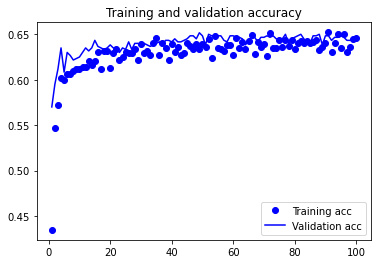

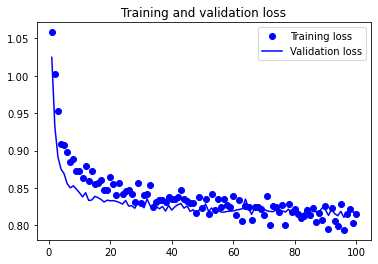

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

If we look at validation accuracy we managed to have it slightly better than Logistic regression accuracy.